In [1]:
%load_ext autoreload
%autoreload 2

Physiological signals, like EEG, EOG, and EMG, contain a wide range of frequency components, not all of which are relevant for sleep analysis. Noise and artifacts outside the relevant frequency bands can obscure the features that are indicative of specific sleep stages. By applying a bandpass filter, we can remove these unwanted components, reducing noise and improving the quality of the signal for analysis.

The `bandpass_filter` function is designed to preprocess physiological signals, specifically those used in sleep stage classification projects. Its primary purpose is to isolate the frequency components that are most relevant for identifying different sleep stages, thereby enhancing the signal's characteristics that are crucial for accurate classification.

**How It Works**
The function implements a digital bandpass filter using a second-order sections (SOS) design for improved numerical stability. We can specify low and high cutoff frequencies to define the desired frequency band. The filter can be applied in a zero-phase manner using `sosfiltfilt` to avoid phase distortion, which is crucial for maintaining the integrity of signal features. Alternatively, for real-time applications, the filter can be applied in a forward direction only using `sosfilt`.


**What It Achieves**
By filtering the signal, this function achieves several key objectives:
- **Noise Reduction:** Eliminates high-frequency noise and low-frequency drift that are not relevant to sleep stage classification.
- **Feature Enhancement:** Highlights the frequency bands that are most informative for distinguishing between sleep stages, such as delta waves for deep sleep or sleep spindles for light sleep.
- **Signal Quality Improvement:** Improves the overall quality of the signal, making it more suitable for feature extraction and machine learning classification.

This preprocessing step can significantly enhance model accuracy by focusing the analysis on the most relevant signal characteristics.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sleep_stage_classifier.config import PARTICIPANT_SHEET
from sleep_stage_classifier.data_model import PSG, Hypnogram

In [3]:
import numpy as np
from scipy.signal import butter, sosfiltfilt, sosfilt

def bandpass_filter(data, lowcut, highcut, sampling_rate, order=5, zero_phase=True):
    """
    Apply bandpass filter to a signal with an option to choose zero-phase filtering.

    Parameters:
    - data (numpy array): The input signal.
    - lowcut (float): Low cutoff frequency for the high-pass filter.
    - highcut (float): High cutoff frequency for the low-pass filter.
    - sampling_rate (float): Sampling frequency of the input signal.
    - order (int): Order of the filter.
    - zero_phase (bool): If True, use zero-phase filtering (sosfiltfilt). If False, use forward filtering (sosfilt).

    Returns:
    - numpy array: Filtered signal.
    """
    
    if sampling_rate <= highcut * 2:
        return data

    nyquist_freq = 0.5 * sampling_rate
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    
    # Design the filter
    sos = butter(order, [low, high], btype='band', output='sos')
    
    # Apply the filter
    if zero_phase:
        filtered_data = sosfiltfilt(sos, data)
    else:
        filtered_data = sosfilt(sos, data)
        
    return filtered_data


In [4]:
participants = pd.read_csv(PARTICIPANT_SHEET)
psg_file = participants['psg_file'].iloc[0]
hypnogram_file = participants['hypnogram_file'].iloc[0]

psg = PSG(psg_file)
hypnogram = Hypnogram(hypnogram_file)

In [5]:
print(psg.get_signal_labels())
psg.close()

['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']


- EEG Signals ('EEG Fpz-Cz', 'EEG Pz-Oz'): EEG signals are crucial for sleep stage classification. Different sleep stages are characterized by distinct EEG patterns. Applying the bandpass filter to EEG signals can help in emphasizing features like sleep spindles and K-complexes, which are significant markers for sleep stages N2 and N3.

- EOG Signal ('EOG horizontal'): The EOG signal, which measures eye movements, is particularly important for identifying REM sleep, characterized by rapid eye movements. Filtering this signal can help in reducing noise and enhancing the detection of these movements.

- EMG Signal ('EMG submental'): The EMG signal provides information about muscle tone, which decreases significantly during REM sleep. Filtering this signal can help in distinguishing REM sleep from other stages, especially from the wakefulness stage, which typically shows higher muscle tone.

- Resp Signal ('Resp oro-nasal'): While not always used directly for sleep stage classification, the respiratory signal can provide additional context, especially for detecting sleep disorders like apneas. (will revisit it later)

- 'Temp rectal' and 'Event marker': These signals are generally not relevant for sleep stage classification and might not need filtering in the context of this project.

**EEG Signals**
- Lowcut: 0.5 Hz is a common choice for EEG signals to remove the DC offset and very slow drifts that are not relevant to sleep stage analysis.
- Highcut: 40 Hz encompasses the delta (0.5-4 Hz), theta (4-8 Hz), alpha (8-13 Hz), and beta (13-30 Hz) bands, all of which can contain important information for sleep stage classification. Frequencies above 40 Hz (gamma band) are less commonly used in sleep analysis.
  
**EOG Signals**
- Lowcut: 0.5 Hz helps to remove slow drifts while retaining the frequency components relevant to eye movements, including slow rolling eye movements and rapid eye movements characteristic of REM sleep.
- Highcut: 15 Hz is sufficient to capture eye movements as they typically fall within lower frequency ranges. This setting helps to exclude higher frequency noise.
  
**EMG Signals**
- Lowcut: 10 Hz is used to focus on the muscle activity frequency range, effectively excluding lower frequency movements that are not indicative of muscle tone.
- Highcut: 100 Hz captures the relevant range of muscle activity frequencies while filtering out higher frequency noise not related to muscle tone variations. EMG signals can have significant components in this range, especially considering the muscle tone variations between REM and non-REM sleep.

In [6]:
filter_settings = {
    'EEG': {'lowcut': 0.5, 'highcut': 40},
    'EOG': {'lowcut': 0.5, 'highcut': 15},
    'EMG': {'lowcut': 10, 'highcut': 100},
}

In [11]:
# Transformer class to do the filtering
from sklearn.base import BaseEstimator, TransformerMixin

class BandpassFilter(BaseEstimator, TransformerMixin):
    
    def __init__(self, filter_settings=None):
        if filter_settings is None:
            filter_settings = {
                'EEG': {'lowcut': 0.5, 'highcut': 40},
                'EOG': {'lowcut': 0.5, 'highcut': 15},
                'EMG': {'lowcut': 10, 'highcut': 100},
            }
        else:
            self.filter_settings = filter_settings  
        self.signal_labels = None
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if isinstance(X, PSG):
            X = [X]
        X_transformed = []            
        for x in X:
            X_transformed.append(self._transform(x))
        
        if len(X_transformed) == 1:
            X_transformed = X_transformed[0]    
        
        return X_transformed
    
    def _transform(self, psg):
        signal_labels = psg.get_signal_labels()
        for signal_label in signal_labels:
            signal = psg.get_signal(signal_label)
            signal_type = signal_label.split(' ')[0]
            if signal_type not in ['EEG', 'EOG', 'EMG']:
                continue
            lowcut = self.filter_settings[signal_type]['lowcut']
            highcut = self.filter_settings[signal_type]['highcut']
            sampling_rate = psg.get_sampling_frequency(signal_label)
            filtered_signal = bandpass_filter(signal, lowcut, highcut, sampling_rate)
            psg.set_signal(signal_label, filtered_signal)
        return psg

    
    def fit_transform(self, X: PSG, y=None):
        try:
            self.fit(X)
            X_transformed = self.transform(X)
        except Exception as e:
            print(e)
            X_transformed = X
        X.close()
        return X_transformed

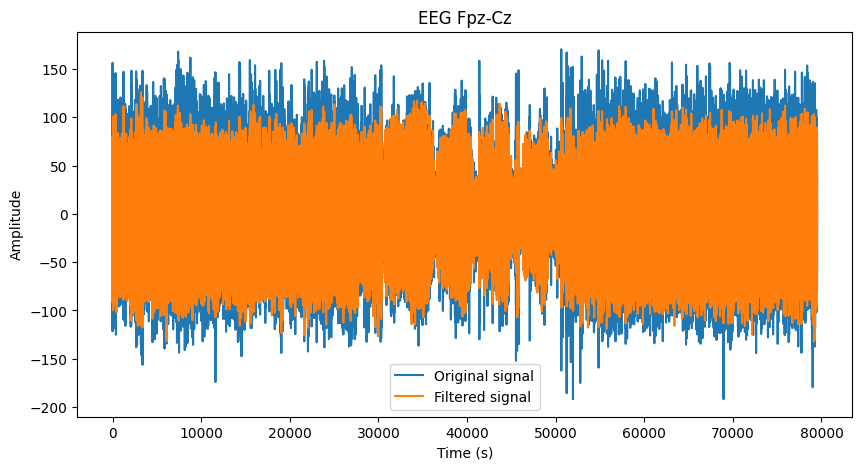

In [12]:
# Create the transformer
bp = BandpassFilter(filter_settings)

# Fit and transform the PSG
psg = PSG(psg_file)
filtered_psg = bp.fit_transform(psg)


signal_label = 'EEG Fpz-Cz'
signal = psg.get_signal(signal_label)
filtered_signal = filtered_psg.get_signal(signal_label, filtered=True)

time = np.arange(0, len(signal)) / psg.get_sampling_frequency(signal_label)

plt.figure(figsize=(10, 5))
plt.plot(time, signal, label='Original signal')
plt.plot(time, filtered_signal, label='Filtered signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(signal_label)
plt.legend()
plt.show()